Ссылка на GitHub репозиторий: https://github.com/GasimV/Supervised-Machine-Learning

## 1. Подготовка данных.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
import dtale
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('E:/Software/Yandex Practicum/Datasets/churn_beta_bank.csv')

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# Удалим ненужные столбцы
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Удалим пропущенные значения
data = data.dropna()

# Конвертируем категориальные переменные в числовые переменные, используя дамми-переменные
data = pd.get_dummies(data, drop_first=True)

# Разделим данные на целевой и обучающие признаки
target = data['Exited']
features = data.drop('Exited', axis=1)

Удаление строк с пропущенными значениями (NaN) из набора данных может быть разумным подходом, если процент пропущенных значений относительно невелик и эти пропущенные значения отсутствуют совершенно случайно. В таких случаях удаление строк с пропущенными значениями не окажет существенного влияния на статистические свойства оставшихся данных и, следовательно, на выводы, которые можно сделать из анализа, как в нашем случае! В этом можно убедиться, посмотрев на изначальный необработанный датасет, где единственный столбец Tenure имел всего лишь 909 пропущенных значений из 10.000.

In [5]:
dtale.show(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Age                9091 non-null   int64  
 2   Tenure             9091 non-null   float64
 3   Balance            9091 non-null   float64
 4   NumOfProducts      9091 non-null   int64  
 5   HasCrCard          9091 non-null   int64  
 6   IsActiveMember     9091 non-null   int64  
 7   EstimatedSalary    9091 non-null   float64
 8   Exited             9091 non-null   int64  
 9   Geography_Germany  9091 non-null   uint8  
 10  Geography_Spain    9091 non-null   uint8  
 11  Gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 736.9 KB


## 2. Исследование задачи.

Исследуем баланс классов и потренируем модель логистической регрессии без учета дисбаланса.

In [7]:
print('Количество положительных экземпляров:', target.sum())
print()
print('Количество отрицательных экземпляров:', (target == 0).sum())

Количество положительных экземпляров: 1854

Количество отрицательных экземпляров: 7237


*Набор данных несбалансирован, только 20% положительных экземпляров. Это указывает на то, что положительных примеров (то есть клиентов, которые покинули банк) значительно меньше, чем отрицательных (клиентов, которые остались). Это важно отметить, потому что несбалансированный набор данных может повлиять на производительность некоторых алгоритмов машинного обучения, поскольку они склонны отдавать предпочтение классу большинства.*

In [8]:
# Разделим данные на обучающие, валидационные и тестовые выборки.

# Разделим данные сначала на обучающие и тестовые выборки со стратификацией, чтобы скорректировать смещение прогноза.
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, 
                                                                            random_state=12345, stratify=target)

# И затем разделим уже обучающий набор на тренировочный и валидационные выборки со стратификацией.
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25,
                                                                              random_state=12345, stratify=target_train)

In [9]:
# Стандартизируем признаки в обоих наборах с помощью StandardScaler(). 
scaler = StandardScaler()
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()
features_train[numerical_cols] = scaler.fit_transform(features_train[numerical_cols])
features_valid[numerical_cols] = scaler.transform(features_valid[numerical_cols])
features_test[numerical_cols] = scaler.transform(features_test[numerical_cols])

In [10]:
# Обучим модель логистической регрессии без учета дисбаланса классов и сделаем прогноз.
best_score = 0
best_params = None

for max_iter in range(0, 1000, 10):
    model_lr = LogisticRegression(random_state=12345, max_iter=max_iter, solver='liblinear')
    model_lr.fit(features_train, target_train)
    predicted_valid_lr = model_lr.predict(features_valid)
    predicted_prob_lr = model_lr.predict_proba(features_valid)[:, 1]  # predicting the class probabilities for positive class

    f1 = f1_score(target_valid, predicted_valid_lr)
    auc_roc = roc_auc_score(target_valid, predicted_prob_lr)  # calculating the AUC-ROC using predicted class probabilities

    if f1 > best_score:
        best_score = f1
        best_params = {'max_iter': max_iter}

print('Лучшие гиперпараметры:', best_params)
model_lr = LogisticRegression(random_state=12345, solver='liblinear', **best_params)
model_lr.fit(features_train, target_train)
predicted_valid_lr = model_lr.predict(features_valid)
predicted_prob_lr = model_lr.predict_proba(features_valid)[:, 1]  # predicting the class probabilities for positive class
print('F1-оценка лог. рег. без учета дисбаланса классов: {:.2f}'.format(f1_score(target_valid, predicted_valid_lr)))
print('Оценка AUC-ROC лог. рег. без учета дисбаланса классов: {:.2f}'.format(roc_auc_score(target_valid, predicted_prob_lr)))

C:\Users\GasimV\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Лучшие гиперпараметры: {'max_iter': 10}
F1-оценка лог. рег. без учета дисбаланса классов: 0.28
Оценка AUC-ROC лог. рег. без учета дисбаланса классов: 0.76


In [11]:
print(classification_report(target_valid, predicted_valid_lr))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89      1447
           1       0.56      0.19      0.28       371

    accuracy                           0.80      1818
   macro avg       0.69      0.58      0.58      1818
weighted avg       0.77      0.80      0.76      1818



Из отчета о классификации видно, что модель хорошо работает в прогнозировании клиентов, которые не собираются уходить, но имеет низкую эффективность в выявлении клиентов, которые собираются уходить. Поэтому может потребоваться улучшить способность модели идентифицировать ушедших клиентов, чтобы делать более точные прогнозы либо использовать другие модели.

In [12]:
confusion_matrix(target_valid, predicted_valid_lr)

array([[1393,   54],
       [ 301,   70]], dtype=int64)

В нашем случае матрица ошибок показывает, что модель правильно идентифицировала большое количество отрицательных случаев (клиенты, которые не ушли), но также имеет большое количество ложноотрицательных результатов (клиенты, которые фактически ушли, но, по прогнозам, останутся). Это говорит о том, что модель может не учитывать все важные факторы, влияющие на отток клиентов, и, возможно, ее необходимо улучшить, включив дополнительные признаки, изменив гиперпараметры модели или использовать другую модель.

In [13]:
# Обучим и проверим классификатор случайного леса без учета дисбаланса.
best_score = 0
best_params = {}

for n_estimators in range(10, 101, 10):
    for max_depth in range(1, 16):
        model_rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=12345)
        model_rfc.fit(features_train, target_train)
        predicted_valid_rfc = model_rfc.predict(features_valid)
        predicted_prob_rfc = model_rfc.predict_proba(features_valid)[:, 1]

        f1 = f1_score(target_valid, predicted_valid_rfc)
        auc_roc = roc_auc_score(target_valid, predicted_prob_rfc)

        if f1 > best_score:
            best_score = f1
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

print('Лучшие гиперпараметры:', best_params)
model_rfc = RandomForestClassifier(random_state=12345, **best_params)
model_rfc.fit(features_train, target_train)
predicted_valid_rfc = model_rfc.predict(features_valid)
predicted_prob_rfc = model_rfc.predict_proba(features_valid)[:, 1] 
print('F1-оценка случайного леса без учета дисбаланса классов: {:.2f}'.format(f1_score(target_valid, predicted_valid_rfc)))
print('Оценка AUC-ROC случайного леса без учета дисбаланса классов: {:.2f}'.format(roc_auc_score(target_valid, predicted_prob_rfc)))

Лучшие гиперпараметры: {'n_estimators': 20, 'max_depth': 11}
F1-оценка случайного леса без учета дисбаланса классов: 0.59
Оценка AUC-ROC случайного леса без учета дисбаланса классов: 0.86


In [14]:
print(classification_report(target_valid, predicted_valid_rfc))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1447
           1       0.79      0.47      0.59       371

    accuracy                           0.87      1818
   macro avg       0.83      0.72      0.75      1818
weighted avg       0.86      0.87      0.85      1818



In [15]:
confusion_matrix(target_valid, predicted_valid_rfc)

array([[1400,   47],
       [ 197,  174]], dtype=int64)

Заметен рост показателей, по сравнению с логистической регрессией и целевая метрика достигнута, но необходимо проработать дисбаланс классов при помощи библиотеки imblearn чтобы посмотреть улучшится ли результат.

## 3. Борьба с дисбалансом.

Улучшим качество модели с учетом дисбаланса классов. Для этого обучим разные модели и найдем лучшую.

In [16]:
# Увеличим выборку класса меньшинства, используя SMOTE.
best_score = 0
best_params = {}

smote = SMOTE(random_state=12345)

for n_estimators in range(10, 151, 10):
    for max_depth in range(1, 30):
        model_rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=12345)

        features_train_resampled, target_train_resampled = smote.fit_resample(features_train, target_train)
        model_rfc.fit(features_train_resampled, target_train_resampled)

        predicted_valid_rfc = model_rfc.predict(features_valid)
        predicted_valid_rfc_proba = model_rfc.predict_proba(features_valid)[:,1]

        f1 = f1_score(target_valid, predicted_valid_rfc)
        auc_roc = roc_auc_score(target_valid, predicted_valid_rfc_proba)

        if f1 > best_score:
            best_score = f1
            best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}

print('Лучшие гиперпараметры:', best_params)

model_rfc_smote = RandomForestClassifier(random_state=12345, **best_params)
features_train_resampled, target_train_resampled = smote.fit_resample(features_train, target_train)
model_rfc_smote.fit(features_train_resampled, target_train_resampled)

predicted_valid_rfc_smote = model_rfc_smote.predict(features_valid)
predicted_valid_rfc_smote_proba = model_rfc_smote.predict_proba(features_valid)[:,1]

print('F1-оценка случайного леса с учетом дисбаланса классов: {:.2f}'.format(f1_score(target_valid, predicted_valid_rfc_smote)))
print('Оценка AUC-ROC случайного леса с учетом дисбаланса классов: {:.2f}'.format(roc_auc_score(target_valid, predicted_valid_rfc_smote_proba)))

Лучшие гиперпараметры: {'n_estimators': 130, 'max_depth': 12}
F1-оценка случайного леса с учетом дисбаланса классов: 0.60
Оценка AUC-ROC случайного леса с учетом дисбаланса классов: 0.85


Важнейшие 10 Признаков:
  Age: 0.304
  NumOfProducts: 0.152
  Balance: 0.111
  EstimatedSalary: 0.090
  CreditScore: 0.087
  IsActiveMember: 0.078
  Tenure: 0.077
  Gender_Male: 0.050
  Geography_Germany: 0.020
  Geography_Spain: 0.019


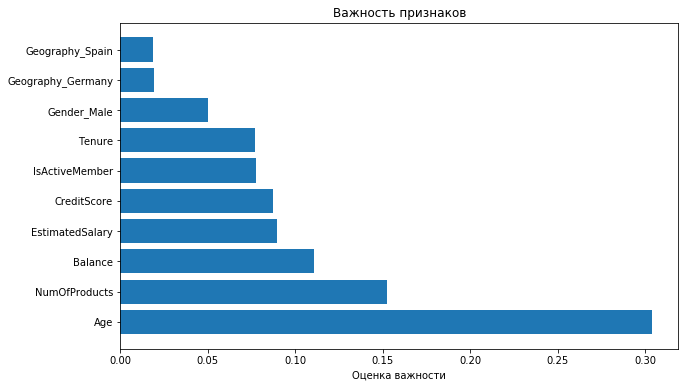

In [24]:
# Расчет важности признаков
importances = model_rfc_smote.feature_importances_
feature_names = features_train.columns

# Сортировка важности признаков в порядке убывания
indices = np.argsort(importances)[::-1]

# Выбор важнейших N признаков
top_n = 10
top_features = feature_names[indices][:top_n]
top_importances = importances[indices][:top_n]

# Распечатка и визуализация N важнейших признаков
print("Важнейшие {} Признаков:".format(top_n))
for feature, importance in zip(top_features, top_importances):
    print("  {}: {:.3f}".format(feature, importance))

plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.barh(range(top_n), top_importances, align='center')
plt.yticks(range(top_n), top_features)
plt.xlabel("Оценка важности")
plt.show()

In [17]:
print(classification_report(target_valid, predicted_valid_rfc_smote))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1447
           1       0.57      0.63      0.60       371

    accuracy                           0.83      1818
   macro avg       0.74      0.76      0.74      1818
weighted avg       0.84      0.83      0.83      1818



In [18]:
confusion_matrix(target_valid, predicted_valid_rfc_smote)

array([[1269,  178],
       [ 136,  235]], dtype=int64)

- Результаты показывают, что использование SMOTE для устранения дисбаланса классов в обучающих данных - улучшило оценку F1 на валидационной выборке по сравнению с предыдущей моделью без SMOTE.

- Оценка F1 на валидационной выборке составляет 0.60, что лучше, чем оценка F1 предыдущей модели, равная 0.59, что указывает на то, что метод SMOTE улучшил способность модели предсказывать класс меньшинства.

- Оценка AUC-ROC составляет 0.85, что является относительно высоким показателем, указывающим на то, что модель обладает хорошей способностью различать положительные и отрицательные классы.

## 4. Тестирование модели.

In [19]:
# Оценим производительность моделей на тестовых данных
predictions_test = model_rfc_smote.predict(features_test)
predicted_test_rfc_smote_proba = model_rfc_smote.predict_proba(features_test)[:,1]

f1 = f1_score(target_test, predictions_test)
auc_roc = roc_auc_score(target_test, predicted_test_rfc_smote_proba)
print("Окончательные результаты тестирования классификатора случайного леса с увеличением выборки с помощью метода SMOTE.")
print("F1: {:.2f}".format(f1))
print("AUC-ROC: {:.2f}".format(auc_roc))

Окончательные результаты тестирования классификатора случайного леса с увеличением выборки с помощью метода SMOTE.
F1: 0.60
AUC-ROC: 0.85


**Вывод**

   1. Судя по результатам, классификатор случайного леса с увеличением числа примеров миноритарного класса при помощи метода SMOTE превзошел две другие модели. Показатель F1 достиг целевого показателя (0.59) на тестовой выборке, а показатель AUC-ROC составил 0.84. Эти улучшения предполагают, что метод SMOTE успешно сбалансировал данные и улучшил общую производительность модели.  


   2. При сравнении двух моделей, в которых не учитывался дисбаланс, классификатор случайного леса работал лучше, чем модель логистической регрессии, с точки зрения обоих метрик (F1 и AUC-ROC). Это говорит о том, что модель случайного леса может лучше подходить для этого конкретного набора данных.  

В целом - основной вывод такой, что при построении моделей машинного обучения важно учитывать дисбаланс классов. SMOTE является эффективным методом, используемым для устранения дисбаланса классов, и полученные здесь результаты показывают, что он может быть эффективным также для улучшения производительности модели. Однако важно отметить, что результаты могут различаться в зависимости от конкретного набора данных и используемой модели, и может потребоваться попробовать несколько методов, чтобы найти наилучший подход для конкретной проблемы.